RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query.
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How?

It starts with better search.

In [1]:
!nvidia-smi


Tue Apr  9 07:58:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Requirements and setup

In [2]:
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch --quiet # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF --quiet # for reading PDFs with Python
    !pip install tqdm --quiet # for progress bars
    !pip install sentence-transformers --quiet # for embedding models
    !pip install accelerate --quiet # for quantization model loading
    !pip install bitsandbytes --quiet # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation --quiet # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 780.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document


In [74]:
from google.colab import drive
import os

# This will prompt for authorization.
drive.mount('/content/drive')

# Specify the path to your file on Google Drive

pdf_path = "/content/drive/MyDrive/AI/GCP_RAG/Google Cloud Certified Professional Cloud Network Engineer.pdf"

# Check if the file exists
if os.path.exists(pdf_path):
    print(f"File {pdf_path} exists.")
else:
    print(f"File does not exist at {pdf_path}. Please check the path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File /content/drive/MyDrive/AI/GCP_RAG/Google Cloud Certified Professional Cloud Network Engineer.pdf exists.


In [78]:
import fitz
import re
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
     # note: this might be different for each doc (best to experiment)

    """Removes unnecessary spaces around punctuation and in general text."""

    cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    cleaned_text = re.sub(r'\s([?.!",](?:\s|$))', r'\1', text)  # Remove space before punctuation

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc

def open_and_read_pdf(pdf_path: str, last_page: int) -> list[dict]:
    """
    Opens a PDF file, reads its text content up to a specified page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.
        last_page (int): Last page to read, exclusive.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc), total=last_page):  # iterate the document pages
        if page_number >= last_page:
            break
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars
                                "text": text})
    return pages_and_texts

# You would call this function with the path to your PDF and the last page you want included.
# For example, to read up to page 369 (since 370 and onwards are to be excluded):
pages_and_texts = open_and_read_pdf(pdf_path, last_page=370) # not interested in the information after page 370
pages_and_texts[:2]

  0%|          | 0/370 [00:00<?, ?it/s]

[{'page_number': 0,
  'page_char_count': 178,
  'page_word_count': 23,
  'page_sentence_count_raw': 1,
  'page_token_count': 44.5,
  'text': 'Google Cloud Certiﬁ\n ed \nProfessional Cloud Network \nEngineer Guide\nDesign, implement, manage, and secure a network \narchitecture in Google Cloud\nMaurizio Ipsale | Mirko Gilioli\n'},
 {'page_number': 1,
  'page_char_count': 194,
  'page_word_count': 20,
  'page_sentence_count_raw': 1,
  'page_token_count': 48.5,
  'text': 'Google Cloud \nCertified Professional \nCloud Network \nEngineer Guide\nDesign, implement, manage, and secure a network \narchitecture in Google Cloud\nMaurizio Ipsale\nMirko Gilioli\nBIRMINGHAM—MUMBAI\n'}]

In [79]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 366,
  'page_char_count': 409,
  'page_word_count': 73,
  'page_sentence_count_raw': 3,
  'page_token_count': 102.25,
  'text': '350     Advanced Networking in Google Cloud Platform\nAs Figure 8.75 shows, the two spokes (bo1 and bo2) appear as Active. You can check the \ndetails by clicking on each spoke name, as Figure 8.76 shows:\nFigure 8.76 – The details of the bo1 spoke\nAs Figure 8.76 shows, the bo1 spoke has VPN tunnels established correctly. bo2 appears \nthe same, as Figure 8.77 shows:\nFigure 8.77 – The details of the bo2 spoke\n'},
 {'page_number': 96,
  'page_char_count': 1133,
  'page_word_count': 176,
  'page_sentence_count_raw': 5,
  'page_token_count': 283.25,
  'text': '80     Designing, Planning, and Prototyping a GCP Network\nTo summarize the differences between Classic VPN and HA VPN, you can refer to the \nfollowing table:\nTable 2.9 – HA VPN versus Classic VPN in GCP\nNow that you have learned all the possible solutions for interconnecting your Go

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

In [80]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,178,23,1,44.50,Google Cloud Certiﬁ\n ed \nProfessional Cloud ...
1,1,194,20,1,48.50,Google Cloud \nCertified Professional \nCloud ...
2,2,1531,202,5,382.75,Google Cloud Certified Professional Cloud \nNe...
3,3,1026,181,7,256.50,Writing this book was harder than I thought bu...
4,4,1563,244,10,390.75,Contributors\nAbout the authors\nMaurizio Ipsa...


In [81]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,370.00,370.00,370.00,370.00,370.00
mean,184.50,1059.78,166.99,5.54,264.94
std,106.95,632.93,97.64,4.15,158.23
min,0.00,0.00,1.00,1.00,0.00
25%,92.25,568.25,93.25,2.25,142.06
50%,184.50,960.00,150.50,4.00,240.00
75%,276.75,1412.50,224.00,8.00,353.12
max,369.00,3278.00,502.00,24.00,819.50


Okay, looks like our average token count per page is 264.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)


As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.



In [82]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

 -let's run our small sentencizing pipeline on our pages of text.

In [83]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/370 [00:00<?, ?it/s]

In [84]:
import random
# Inspect an example
random.sample(pages_and_texts, k=1)


[{'page_number': 251,
  'page_char_count': 771,
  'page_word_count': 131,
  'page_sentence_count_raw': 5,
  'page_token_count': 192.75,
  'text': "Summary     235\nFigure 5.55 – Advertised route priority (MED value)\nThis is useful whenever you have more than one connection exiting from your VPC  \n(HA VPN), and you want to select the preferred way. A MED's behavior is similar to  \nthat of a metric, so a lower value is preferred over a higher value.\nSummary\nIn this chapter, you have learned how to interconnect your on-premises network with  \na Google Cloud VPC. You have been through Dedicated Interconnect as well as Partner \nInterconnect solutions. Then, you also have learned how to connect your on-premises \nnetwork using Cloud VPN in Classic mode and in HA mode. Now that you have learned \nhow to implement hybrid connectivity in GCP, let's go through the network security \nimplementation in the next chapter.\n",
  'sentences': ['Summary     235\nFigure 5.55 – Advertised route pr

Let's take our list of dictionaries and transform it into a Dataframe and get some stats

In [85]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,370.00,370.00,370.00,370.00,370.00,370.00
mean,184.50,1059.78,166.99,5.54,264.94,7.42
std,106.95,632.93,97.64,4.15,158.23,5.68
min,0.00,0.00,1.00,1.00,0.00,0.00
25%,92.25,568.25,93.25,2.25,142.06,3.00
50%,184.50,960.00,150.50,4.00,240.00,6.00
75%,276.75,1412.50,224.00,8.00,353.12,10.00
max,369.00,3278.00,502.00,24.00,819.50,28.00


### Chunking our sentences together

Let's  break down our list of sentences/text into smaller chunks.


Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 8

On average each of our pages has 8 sentences.

And an average total of 265 tokens per page.


This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [86]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 8

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/370 [00:00<?, ?it/s]

In [87]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 193,
  'page_char_count': 421,
  'page_word_count': 65,
  'page_sentence_count_raw': 3,
  'page_token_count': 105.25,
  'text': 'Configuring load balancing     177\nNext, we will create two MIGs to implement the Apache frontend with autoscaling. We will \nuse the same instance templates in two zones, us-central1-a and us-central1-b. \nThe following screenshot shows the first one:\nFigure 4.27 – Managed instance group for us-central1-a\nWhen both MIGs have been created, you will see the following output:\nFigure 4.28 – List of managed instance groups\n',
  'sentences': ['Configuring load balancing     177\nNext, we will create two MIGs to implement the Apache frontend with autoscaling.',
   'We will \nuse the same instance templates in two zones, us-central1-a and us-central1-b. \nThe following screenshot shows the first one:\nFigure 4.27 – Managed instance group for us-central1-a\nWhen both MIGs have been created, you will see the following output:\nFigure 4.28 – List 

In [88]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,370.00,370.00,370.00,370.00,370.00,370.00,370.00
mean,184.50,1059.78,166.99,5.54,264.94,7.42,1.42
std,106.95,632.93,97.64,4.15,158.23,5.68,0.69
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,92.25,568.25,93.25,2.25,142.06,3.00,1.00
50%,184.50,960.00,150.50,4.00,240.00,6.00,1.00
75%,276.75,1412.50,224.00,8.00,353.12,10.00,2.00
max,369.00,3278.00,502.00,24.00,819.50,28.00,4.00


### Splitting each chunk into its own item

Let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [89]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/370 [00:00<?, ?it/s]

527

In [90]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 37,
  'sentence_chunk': "Getting started with GCP   21\nThe first two operating modes are more appropriate for cloud architects and \nadministrators who prefer to have direct interaction with GCP. The other two are chosen \nby programmers and developers who build applications that use GCP services. In this \nbook, we will focus more on the Console and Cloud Shell to explain GCP features.\nThe following screenshot shows the main components of the Console:\n \nFigure 1.14 – Main components of the GCP Console\nLet's explore what's labeled in the preceding screenshot:\n•\t The navigation menu lets you access all the GCP services and resources (1).\n•\t The combo menu lets you select the project you want to work with (2).\n•\t The search bar lets you search for resources and more within the project (3).\n•\t The Cloud Shell button lets you start the Cloud Shell (4).\n•\t The Project Info card lets you control the project settings (5).",
  'chunk_char_count': 900,
  'chunk_w

In [91]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,527.0,527.00,527.00,527.00
mean,169.1,740.54,114.82,185.13
std,108.3,386.56,59.38,96.64
min,0.0,0.00,1.00,0.00
25%,71.5,431.00,69.50,107.75
50%,152.0,770.00,119.00,192.50
75%,265.5,1017.00,158.00,254.25
max,369.0,1811.00,270.00,452.75


In [97]:
# Show random chunks with under 20 tokens in length
min_token_length = 20

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 0.0 | Text: 
Chunk token count: 0.0 | Text: 
Chunk token count: 13.0 | Text: A new wizard will guide you to the service creation.
Chunk token count: 0.0 | Text: 
Chunk token count: 0.0 | Text: 




Let's filter our DataFrame/list of dictionaries to only include chunks with over 20 tokens in length.

In [98]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': 'Google Cloud Certiﬁ\n ed \nProfessional Cloud Network \nEngineer Guide\nDesign, implement, manage, and secure a network \narchitecture in Google Cloud\nMaurizio Ipsale | Mirko Gilioli',
  'chunk_char_count': 177,
  'chunk_word_count': 23,
  'chunk_token_count': 44.25},
 {'page_number': 1,
  'sentence_chunk': 'Google Cloud \nCertified Professional \nCloud Network \nEngineer Guide\nDesign, implement, manage, and secure a network \narchitecture in Google Cloud\nMaurizio Ipsale\nMirko Gilioli\nBIRMINGHAM—MUMBAI',
  'chunk_char_count': 193,
  'chunk_word_count': 20,
  'chunk_token_count': 48.25}]

### Embedding our text chunks



Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).


To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [99]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

single_sentence = "This is a test"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: This is a test
Embedding:
[-1.10770194e-02 -9.87184122e-02 -2.17309874e-02  9.86822229e-03
 -2.34005377e-02  4.28259932e-02  5.96765280e-02  4.51825224e-02
  5.96456230e-02  2.93849092e-02  6.90463185e-02 -2.58708745e-02
  3.30726132e-02 -3.02911680e-02  2.75240764e-02 -3.60070877e-02
  2.39568762e-02 -9.27290134e-03 -2.16343328e-02  2.40064748e-02
 -6.57190830e-02  2.65394663e-03 -2.84890365e-02 -3.27286907e-02
 -4.46028588e-03  4.69275564e-02 -1.40922731e-02 -2.70122886e-02
  1.89231941e-03 -3.74078080e-02  2.61785761e-02 -3.26690078e-02
  1.65957715e-02 -7.42781684e-02  1.80516179e-06 -2.48813583e-03
  7.24843005e-03 -2.23124605e-02 -4.73724157e-02 -1.51718529e-02
 -3.05179097e-02  3.18569094e-02 -2.17708647e-02  3.81208435e-02
 -1.28692305e-02 -5.58012500e-02  1.57685466e-02 -8.00077431e-03
 -3.26289460e-02  9.60759670e-02  1.55185414e-02  1.75194927e-02
  1.45062350e-03 -4.19370420e-02  7.55118877e-02  2.08015423e-02
  3.11325975e-02  4.65105549e-02  6.31527510e-03  7.89



Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space
> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.


In [100]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed
# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/502 [00:00<?, ?it/s]

CPU times: user 8.64 s, sys: 55.4 ms, total: 8.69 s
Wall time: 8.92 s



We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [101]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [102]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 5.86 s, sys: 8.66 ms, total: 5.87 s
Wall time: 5.84 s


tensor([[ 4.9749e-02,  4.3295e-03, -2.6346e-02,  ...,  1.6576e-02,
          3.2501e-06, -4.3048e-02],
        [ 5.4282e-02,  3.5953e-03, -3.4256e-02,  ...,  1.8902e-02,
         -6.3760e-03, -4.9697e-02],
        [ 3.4854e-02, -2.3706e-02, -4.0003e-02,  ..., -2.0611e-02,
         -6.5874e-04, -2.7262e-02],
        ...,
        [ 2.3819e-02, -3.2173e-02, -2.8907e-02,  ..., -2.1634e-02,
         -2.4404e-02, -2.1780e-02],
        [ 1.1169e-02, -5.5162e-02, -4.8727e-02,  ..., -1.9329e-03,
          1.1125e-02, -4.3803e-02],
        [ 1.0505e-02, -3.0980e-04, -6.5529e-02,  ..., -4.4756e-02,
         -9.9980e-03, -4.3447e-02]], device='cuda:0')

### Save embeddings to file
 let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [104]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [105]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,Google Cloud Certiﬁ\n ed \nProfessional Cloud ...,177,23,44.25,[ 4.97485735e-02 4.32950351e-03 -2.63463929e-...
1,1,Google Cloud \nCertified Professional \nCloud ...,193,20,48.25,[ 5.42815924e-02 3.59531236e-03 -3.42558436e-...
2,2,Google Cloud Certified Professional Cloud \nNe...,1493,201,373.25,[ 3.48541588e-02 -2.37056762e-02 -4.00031172e-...
3,3,Writing this book was harder than I thought bu...,1021,177,255.25,[-1.38504161e-02 -5.72950207e-02 -4.75824662e-...
4,4,Contributors\nAbout the authors\nMaurizio Ipsa...,1370,210,342.50,[ 1.33798365e-02 2.70734355e-02 -4.73594666e-...


## 2. RAG - Search and Answer





In [106]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([502, 768])

In [107]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,Google Cloud Certiﬁ\n ed \nProfessional Cloud ...,177,23,44.25,"[0.0497485735, 0.00432950351, -0.0263463929, -..."
1,1,Google Cloud \nCertified Professional \nCloud ...,193,20,48.25,"[0.0542815924, 0.00359531236, -0.0342558436, -..."
2,2,Google Cloud Certified Professional Cloud \nNe...,1493,201,373.25,"[0.0348541588, -0.0237056762, -0.0400031172, -..."
3,3,Writing this book was harder than I thought bu...,1021,177,255.25,"[-0.0138504161, -0.0572950207, -0.0475824662, ..."
4,4,Contributors\nAbout the authors\nMaurizio Ipsa...,1370,210,342.50,"[0.0133798365, 0.0270734355, -0.0473594666, 0...."



Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above.

In [108]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

Embedding model ready!

Time to perform a semantic search.


Well, we can do so with the following steps:
1. Define a query string (e.g. `"VPC Networks"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

Easy!


In [109]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "VPC Network"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: VPC Network
Time take to get scores on 502 embeddings: 0.00050 seconds.


torch.return_types.topk(
values=tensor([0.7134, 0.6974, 0.6823, 0.6799, 0.6751], device='cuda:0'),
indices=tensor([221, 146, 231, 199, 238], device='cuda:0'))

In [110]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([50200, 768])
Time take to get scores on 50200 embeddings: 0.00118 seconds.




That means we can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).

Let's check the results of our original similarity search.

[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [111]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.


In [112]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'VPC Network'

Results:
Score: 0.7134
Text:
Configuring VPC networks   113 Configuring static and dynamic routing with Cloud
Router In general, you need to configure static or dynamic routing when you
interconnect your  VPC with an on-premises network. In this section, we will
describe how to manage  routing in your VPC when it is interconnected with your
on-premises network. To also  demonstrate dynamic and static routing, we assume
Cloud VPN will be set up, but this  will be covered in Chapter 5, Implementing
Hybrid Connectivity in GCP. However, static  and dynamic routing can be applied
also to other Cloud Interconnect solutions, such as  Dedicated Interconnect,
Partner Interconnect, and so on. In the following table, you can  see a
comparison between the different solutions:
Page number: 129


Score: 0.6974
Text:
Designing a VPC   67 If you need to interconnect Shared VPC with your on-
premises network, this must  be done through the host project. For example, if
you are usi


How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 129 but really page 17 + 129 since our PDF page numbers start on page 17).

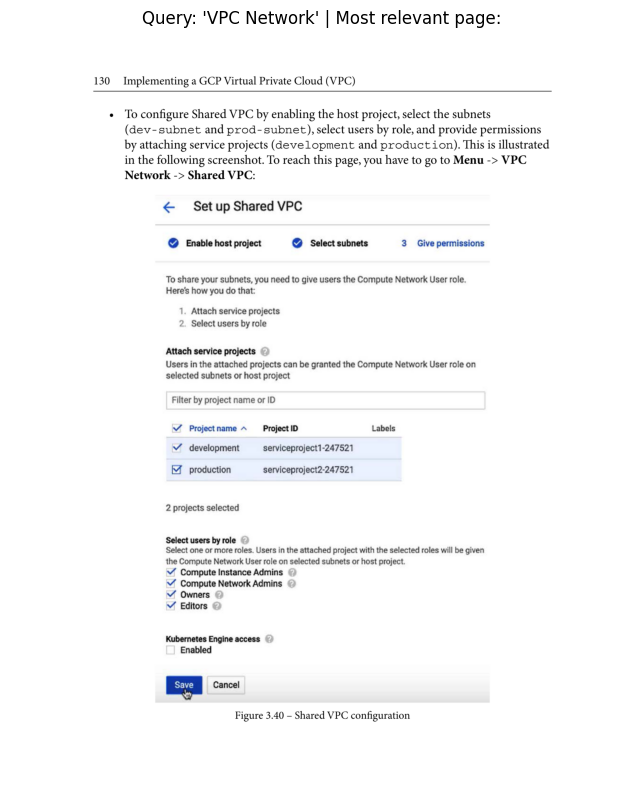

In [115]:
import fitz

# Open PDF and load target page
pdf_path = "/content/drive/MyDrive/AI/GCP_RAG/Google Cloud Certified Professional Cloud Network Engineer.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(129 + 17) # number of page (our doc starts page numbers on page 18(18-1))

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()



We could use semantic search on customer support documents.

Or email threads.

Or company plans.

Or our old journal entries.

Almost anything!

The workflow is the same:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

And we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).



### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [116]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [125]:
query = "Virtual Machines"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 502 embeddings: 0.00009 seconds.


(tensor([0.7152, 0.5766, 0.5414, 0.5375, 0.5130], device='cuda:0'),
 tensor([29, 25, 31, 53, 23], device='cuda:0'))

In [126]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 502 embeddings: 0.00006 seconds.
Query: Virtual Machines

Results:
Score: 0.7152
Introducing cloud computing and virtualization   7 What is virtualization?
Sometimes, in the Information Technology (IT) industry, there is the need to
abstract  hardware components into software components. Virtualization is the
technology that  does this. Today, virtualization is used on servers to abstract
hardware components  (CPU, RAM, and disk) to virtual systems that require them
to run. These virtual systems  are commonly referred to as virtual machines and
the software that abstracts the  hardware components is called a hypervisor. By
using virtualization, IT administrators  can consolidate their physical assets
in multiple virtual machines running on one or  few physical servers.
Hypervisors lets you have multiple virtual machines with different  requirements
in terms of the hardware and operating system. Moreover, the hypervisor
isolates operating systems and t

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally?
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs.

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [127]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [128]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally


To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention).

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html).

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>



In [129]:
from huggingface_hub import login
login()

In [130]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [131]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [132]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [133]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.



In [134]:
input_text = "What is Compute Engine and what rol does it have?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is Compute Engine and what rol does it have?

Prompt (formatted):
<bos><start_of_turn>user
What is Compute Engine and what rol does it have?<end_of_turn>
<start_of_turn>model



Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

We'll make sure our tokenized text is on the same device as our model (GPU) using `to("cuda")`.

Let's generate some text!

We'll time it for fun with the `%%time` magic.

In [135]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,  48100,   6794,
            578,   1212,  17947,   1721,    665,    791, 235336,    107,    108,
            106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,  48100,   6794,
           578,   1212,  17947,   1721,    665,    791, 235336,    107,    108,
           106,   2516,    108,    688,  58970,   6794,    688,    603,    476,
         12238, 235290,   6576,   7134,    674,   6572,  26337,    578,  12065,
           675,    573,   8112,    578,   6336,    984,   1476,    577,   2500,
        235269,  32508, 235269,    578,  12607, 104815,    578,   2458, 235290,
         31024,  12238,   8557, 235265,   1165,   6952,    476,   5396,   3001,
           576,   3545, 235269,   3359, 23529



We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [136]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is Compute Engine and what rol does it have?<end_of_turn>
<start_of_turn>model
**Compute Engine** is a cloud-based platform that provides developers and businesses with the tools and resources they need to build, deploy, and manage scalable and cost-effective cloud applications. It offers a wide range of services, including:

**Key Roles of Compute Engine:**

**1. Application Development and Management:**
- Provides tools and services for building, testing, and deploying applications in the cloud.
- Offers a variety of programming languages and frameworks, including Python, Java, and Node.js.
- Supports various cloud platforms, including Google Cloud Platform (GCP), Microsoft Azure, and Amazon Web Services (AWS).

**2. Serverless Computing:**
- Allows users to run code without managing any servers or infrastructure.
- Provides automatic scaling and resource allocation based on demand.
- Offers a wide range of serverless service

In [137]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is Compute Engine and what rol does it have?

Output text:
**Compute Engine** is a cloud-based platform that provides developers and businesses with the tools and resources they need to build, deploy, and manage scalable and cost-effective cloud applications. It offers a wide range of services, including:

**Key Roles of Compute Engine:**

**1. Application Development and Management:**
- Provides tools and services for building, testing, and deploying applications in the cloud.
- Offers a variety of programming languages and frameworks, including Python, Java, and Node.js.
- Supports various cloud platforms, including Google Cloud Platform (GCP), Microsoft Azure, and Amazon Web Services (AWS).

**2. Serverless Computing:**
- Allows users to run code without managing any servers or infrastructure.
- Provides automatic scaling and resource allocation based on demand.
- Offers a wide range of serverless services, including compute, storage, databases, and networking.

**3



We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [138]:

gpt4_questions = [
"What is the purpose of IAM (Identity and Access Management) in GCP, and how does it contribute to cloud security?",

"Explain the differences between Compute Engine, Kubernetes Engine, App Engine, and Cloud Functions in GCP. When would you choose one over the others?",

"Describe the process of creating and managing virtual machine (VM) instances in Google Compute Engine. Include information on machine types, zones, and preemptible VMs.",

"How do GCP's networking services (VPC, Cloud Load Balancing, Cloud CDN) enhance application performance and security?",

"Explain the concept of 'Infrastructure as Code' (IaC) and its implementation in GCP using Deployment Manager or Terraform. How does IaC benefit cloud architecture management?"
]

# Manually created question list
manual_questions = [
    "How easy is to use Compute Engine",
    "Tell me more about edge devices",
    "How does VPC work",
    "Explain VM's for me?",
    "What is Cloud Spanner?"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [139]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How easy is to use Compute Engine
[INFO] Time taken to get scores on 502 embeddings: 0.00007 seconds.


(tensor([0.5118, 0.4903, 0.4856, 0.4491, 0.4474], device='cuda:0'),
 tensor([53, 56, 92, 52, 23], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [140]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: Company X needs to keep their data available for auditing purposes for 5 years. Which storage option should they choose?
Answer: Google Cloud Coldline Storage. Coldline Storage is designed for data that you plan to access less than once a year, making it suitable for auditing purposes where data needs to be retained for long periods but accessed infrequently​​.
\nExample 2:
Query: You have deployed a virtual machine instance to GCP in project X. Specific configuration and software has been installed on this instance. In order to share this image with other teams that only have access to project Z, what would you advise?
Answer: Create a snapshot. Use the snapshot to create a custom image. Share the image with the other projects. This approach allows you to share the customized setup of your VM across projects, maintaining consistency across your environment​​.
\nExample 3:
Query:Company X is using Hadoop to analyze data. They are using a hybrid cloud mixture of on-premises and GCP infrastructure. They want to move the data analysis to GCP but they want to migrate it with minimal effort. Which service should they use?
Answer: Google Cloud Dataproc. Cloud Dataproc offers a fully managed Hadoop service, making it an ideal choice for migrating existing Hadoop jobs to GCP with minimal effort​​.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [153]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Explain the differences between Compute Engine, Kubernetes Engine, App Engine, and Cloud Functions in GCP. When would you choose one over the others?
[INFO] Time taken to get scores on 502 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: Company X needs to keep their data available for auditing purposes for 5 years. Which storage option should they choose?
Answer: Google Cloud Coldline Storage. Coldline Storage is designed for data that you plan to access less than once a year, making it suitable for auditing purposes where data needs to be retained for long periods but accessed infrequently​​.

Example 2:
Query: You ha

In [154]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Explain the differences between Compute Engine, Kubernetes Engine, App Engine, and Cloud Functions in GCP. When would you choose one over the others?
RAG answer:
<bos>The context does not provide any information about the differences between Compute Engine, Kubernetes Engine, App Engine, and Cloud Functions in GCP, so I cannot answer this query from the provided context.<eos>
CPU times: user 1.84 s, sys: 41.7 ms, total: 1.88 s
Wall time: 1.93 s





We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [143]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [146]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Tell me more about edge devices
[INFO] Time taken to get scores on 502 embeddings: 0.00007 seconds.
Answer:

The context does not provide any relevant information about edge devices, so I
cannot answer this query from the context.
Context items:


[{'page_number': 93,
  'sentence_chunk': 'Direct peering is when customers have \na physical link connecting a port on their device directly to a Google edge device. \nThe Google edge device is located in a colocation facility where Google is present.\n•\t Carrier Peering: This option allows you to establish BGP peering with Google \neven though you are not co-located in one of the Google PoPs. You can achieve this \nthrough a supported SP that provides IP connectivity to the Google network.\nImportant Note\nWith both Direct Peering and Carrier Peering, Google cannot offer SLAs.\nIf your applications require guaranteed interconnection services, the \nrecommendation is to choose Dedicated or Partner Interconnect solutions.',
  'chunk_char_count': 679,
  'chunk_word_count': 102,
  'chunk_token_count': 169.75,
  'embedding': array([ 2.27175504e-02, -6.25049174e-02, -3.77910957e-02, -2.33905744e-02,
         -3.04415952e-02, -6.89246971e-03,  6.61411807e-02, -1.96621437e-02,
          8.18